# TimesFM 2.5: Univariate Blood Glucose Forecasting

**Model**: Google TimesFM 2.5 (200M parameters)  
**Dataset**: Kaggle BrisT1D  
**Task**: Nocturnal blood glucose forecasting (6 hours)  

## Overview

This notebook demonstrates **univariate forecasting** using TimesFM 2.5:
- Uses only historical blood glucose values
- Zero-shot inference with the latest TimesFM API
- Probabilistic outputs with quantile forecasts

## Environment Setup

```bash
# Clone TimesFM repo and install v2.5
git clone https://github.com/google-research/timesfm.git
cd timesfm
pip install -e ".[torch]"
```

In [1]:
import sys
from pathlib import Path

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

from src.data.diabetes_datasets.data_loader import get_loader
from src.data.models import ColumnNames
from src.utils.time_series_helper import get_interval_minutes
from src.data.preprocessing.time_processing import iter_daily_context_forecast_splits

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# Path to local timesfm repo (adjust if needed)
TIMESFM_REPO = Path.cwd() / "timesfm"


def compute_metrics(predictions, targets):
    """Compute RMSE, MAE for forecast evaluation."""
    y_pred = np.asarray(predictions).flatten()
    y_true = np.asarray(targets).flatten()
    return {
        "rmse": float(root_mean_squared_error(y_true, y_pred)),
        "mae": float(mean_absolute_error(y_true, y_pred)),
        "mape": float(
            np.mean(np.abs((y_pred - y_true) / np.where(y_true != 0, y_true, 1e-8)))
            * 100
        ),
    }

Device: cpu


In [2]:
# Configuration
INTERVAL_MINS = 5
NOCTURNAL_HOURS = 6
CONTEXT_LENGTH = 512  # ~42 hours
TARGET_COL = ColumnNames.BG.value

prediction_length = int(NOCTURNAL_HOURS * 60 / INTERVAL_MINS)  # 72 steps
print(f"Predicting {prediction_length} steps ({NOCTURNAL_HOURS} hours)")
print(f"Context length: {CONTEXT_LENGTH} steps (~{CONTEXT_LENGTH * INTERVAL_MINS / 60:.0f} hours)")

Predicting 72 steps (6 hours)
Context length: 512 steps (~43 hours)


In [3]:
# Load data
loader = get_loader(
    data_source_name="kaggle_brisT1D", dataset_type="train", use_cached=True
)
val_data = loader.validation_data

# Ensure TimesFM 2.5 path is first in sys.path
timesfm_25_path = str(TIMESFM_REPO / "src")
if timesfm_25_path not in sys.path:
    sys.path.insert(0, timesfm_25_path)
    print(f"Added TimesFM 2.5 path: {timesfm_25_path}")

import timesfm
print(f"Loaded timesfm from: {timesfm.__file__}")

# Load TimesFM 2.5 model
print("Loading TimesFM 2.5 model...")
torch.set_float32_matmul_precision("high")

model = timesfm.TimesFM_2p5_200M_torch.from_pretrained(
    "google/timesfm-2.5-200m-pytorch"
)

# Compile with configuration
model.compile(timesfm.ForecastConfig(
    max_context=CONTEXT_LENGTH,
    max_horizon=prediction_length,
    normalize_inputs=True,
    use_continuous_quantile_head=True,
    force_flip_invariance=True,
    infer_is_positive=True,
    fix_quantile_crossing=True,
))
print("TimesFM 2.5 model loaded.")

2026-01-28T23:57:00 - ============================================================
2026-01-28T23:57:00 - Beginning data loading process with the following parmeters:
2026-01-28T23:57:00 - 	Dataset: kaggle_brisT1D - train
2026-01-28T23:57:00 - 	Columns: None
2026-01-28T23:57:00 - 	Generic patient start date: 2024-01-01 00:00:00
2026-01-28T23:57:00 - 	Number of validation days: 20
2026-01-28T23:57:00 - 	In parallel with up to 3 workers.

2026-01-28T23:57:00 - Loaded full processed data from cache for 9 patients
2026-01-28T23:57:00 - Loaded existing train/validation split from cache for 9 patients


Added TimesFM 2.5 path: /Users/arohi/Desktop/FYDP/nocturnal-hypo-gly-prob-forecast/docs-internal/notebooks/timesfm/src
Loaded timesfm from: /Users/arohi/Desktop/FYDP/nocturnal-hypo-gly-prob-forecast/timesfm/src/timesfm/__init__.py
Loading TimesFM 2.5 model...


config.json:   0%|          | 0.00/475 [00:00<?, ?B/s]

2026-01-28T23:57:03 - Downloading checkpoint from Hugging Face repo google/timesfm-2.5-200m-pytorch
2026-01-28T23:57:03 - Loading checkpoint from: /Users/arohi/.cache/huggingface/hub/models--google--timesfm-2.5-200m-pytorch/snapshots/1d952420fba87f3c6dee4f240de0f1a0fbc790e3/model.safetensors


Downloaded.


2026-01-28T23:57:06 - When compiling, max horizon needs to be multiple of the output patch size 128. Using max horizon = 128 instead.


TimesFM 2.5 model loaded.


In [4]:
def timesfm_forecast(
    context: np.ndarray,
    prediction_length: int,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Run TimesFM forecast on univariate context.

    Args:
        context: 1D array of historical values
        prediction_length: Number of steps to forecast

    Returns:
        point_forecast: shape (prediction_length,)
        quantile_forecast: shape (prediction_length, num_quantiles)
    """
    # TimesFM expects list of arrays
    point_forecast, quantile_forecast = model.forecast(
        horizon=prediction_length,
        inputs=[context]
    )

    # Extract single series results
    return point_forecast[0], quantile_forecast[0]

## Evaluation

We evaluate TimesFM using a day-split validation strategy for nocturnal hypoglycemia prediction:

- **Context**: Up to 512 steps (~43 hours) of blood glucose history ending at midnight
- **Target**: Nocturnal period from midnight to 6am (72 steps at 5-min intervals)
- **Metrics**: RMSE and MAE in mmol/L

The model receives only the univariate BG signal. This establishes a baseline for comparison with multivariate approaches.

In [5]:
all_preds, all_targets = [], []
patient_metrics = []

for patient_id, patient_df in val_data.items():
    if get_interval_minutes(patient_df) != INTERVAL_MINS:
        continue

    df = patient_df.sort_index()
    preds, targets = [], []

    for daytime, nocturnal in iter_daily_context_forecast_splits(df):
        target = nocturnal[TARGET_COL].values[:prediction_length]

        # Skip if NaN or insufficient data
        if np.isnan(target).any() or len(target) < prediction_length:
            continue

        # Get context ending at midnight
        nocturnal_start = nocturnal.index[0]
        available = df.loc[df.index < nocturnal_start, TARGET_COL].dropna()

        if len(available) < CONTEXT_LENGTH:
            continue

        context = available.iloc[-CONTEXT_LENGTH:].values
        if np.isnan(context).any():
            continue

        pred, quantiles = timesfm_forecast(context, prediction_length)
        preds.append(pred.flatten())
        targets.append(target.flatten())

    if preds:
        preds_flat = np.concatenate(preds)
        targets_flat = np.concatenate(targets)
        metrics = compute_metrics(preds_flat, targets_flat)
        patient_metrics.append(
            {
                "patient": patient_id,
                "rmse": metrics["rmse"],
                "mae": metrics["mae"],
                "days": len(preds),
            }
        )
        all_preds.append(preds_flat)
        all_targets.append(targets_flat)
        print(
            f"{patient_id}: RMSE={metrics['rmse']:.3f}, MAE={metrics['mae']:.3f} ({len(preds)} days)"
        )

if all_preds:
    overall = compute_metrics(np.concatenate(all_preds), np.concatenate(all_targets))
    print(
        f"\nOverall: RMSE={overall['rmse']:.3f}, MAE={overall['mae']:.3f}, MAPE={overall['mape']:.1f}%"
    )

p04: RMSE=1.571, MAE=1.243 (17 days)
p12: RMSE=2.450, MAE=1.768 (16 days)
p03: RMSE=2.919, MAE=2.269 (17 days)
p02: RMSE=2.985, MAE=2.299 (16 days)
p10: RMSE=1.465, MAE=1.136 (17 days)
p11: RMSE=2.245, MAE=1.746 (16 days)

Overall: RMSE=2.341, MAE=1.738, MAPE=21.8%


In [6]:
pd.DataFrame(patient_metrics)

,patient,rmse,mae,days
0,p04,1.570514,1.243453,17
1,p12,2.450215,1.768487,16
2,p03,2.918635,2.269325,17
3,p02,2.985003,2.298684,16
4,p10,1.464921,1.135766,17
5,p11,2.244543,1.746459,16


## Single Patient Visualization

Example forecast showing TimesFM's probabilistic output:

- **Point forecast** (red line): Mean prediction
- **80% Prediction Interval** (red shaded): 10th to 90th percentile bounds
- **Hypoglycemia threshold** (crimson dashed): 3.9 mmol/L
- **Hyperglycemia threshold** (orange dashed): 10.0 mmol/L

The quantile forecasts enable uncertainty-aware decision making for hypoglycemia risk assessment.

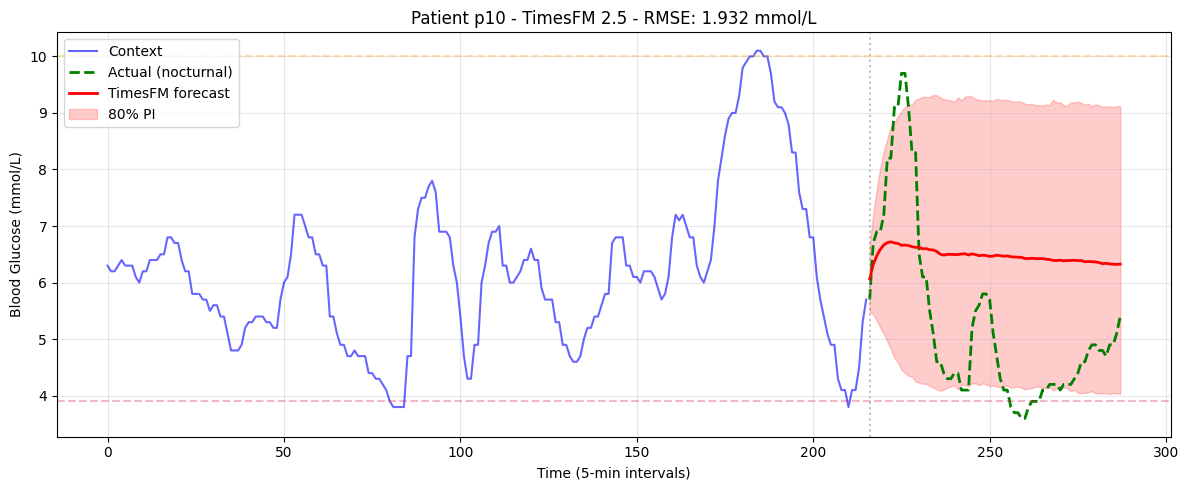

In [7]:
# Pick a patient and get first valid day
PATIENT = "p10"

patient_df = val_data[PATIENT].sort_index()

for daytime, nocturnal in iter_daily_context_forecast_splits(patient_df):
    target = nocturnal[TARGET_COL].values[:prediction_length]

    if np.isnan(target).any() or len(target) < prediction_length:
        continue

    # Get extended context
    nocturnal_start = nocturnal.index[0]
    available = patient_df.loc[patient_df.index < nocturnal_start, TARGET_COL].dropna()

    if len(available) < CONTEXT_LENGTH:
        continue

    context = available.iloc[-CONTEXT_LENGTH:].values
    if np.isnan(context).any():
        continue

    # Forecast
    pred, quantiles = timesfm_forecast(context, prediction_length)
    pred = pred.flatten()

    # TimesFM quantile format: column 0 is median, columns 1-9 are 10th-90th percentiles
    q10 = quantiles[:, 1]  # 10th percentile (lower bound)
    q90 = quantiles[:, 9]  # 90th percentile (upper bound)

    # Plot (show last 216 steps of context for visibility)
    ctx_display = context[-216:]
    fig, ax = plt.subplots(figsize=(12, 5))
    t_ctx = np.arange(len(ctx_display))
    t_pred = np.arange(len(ctx_display), len(ctx_display) + len(target))

    ax.plot(t_ctx, ctx_display, "b-", alpha=0.6, label="Context")
    ax.plot(t_pred, target, "g--", lw=2, label="Actual (nocturnal)")
    ax.plot(t_pred, pred, "r-", lw=2, label="TimesFM forecast")
    ax.fill_between(t_pred, q10, q90, alpha=0.2, color="red", label="80% PI")

    ax.axvline(len(ctx_display), color="gray", ls=":", alpha=0.5)
    ax.axhline(3.9, color="crimson", ls="--", alpha=0.3)  # Hypoglycemia threshold
    ax.axhline(10.0, color="orange", ls="--", alpha=0.3)  # Hyperglycemia threshold

    rmse = compute_metrics(pred, target.flatten())["rmse"]
    ax.set_title(f"Patient {PATIENT} - TimesFM 2.5 - RMSE: {rmse:.3f} mmol/L")
    ax.set_xlabel("Time (5-min intervals)")
    ax.set_ylabel("Blood Glucose (mmol/L)")
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    break

## Patient 10: All Validation Days

Grid visualization of TimesFM forecasts across all 17 validation days for patient p10, who achieved the best overall performance (RMSE = 1.46 mmol/L). This allows examining forecast quality variation across different nights.

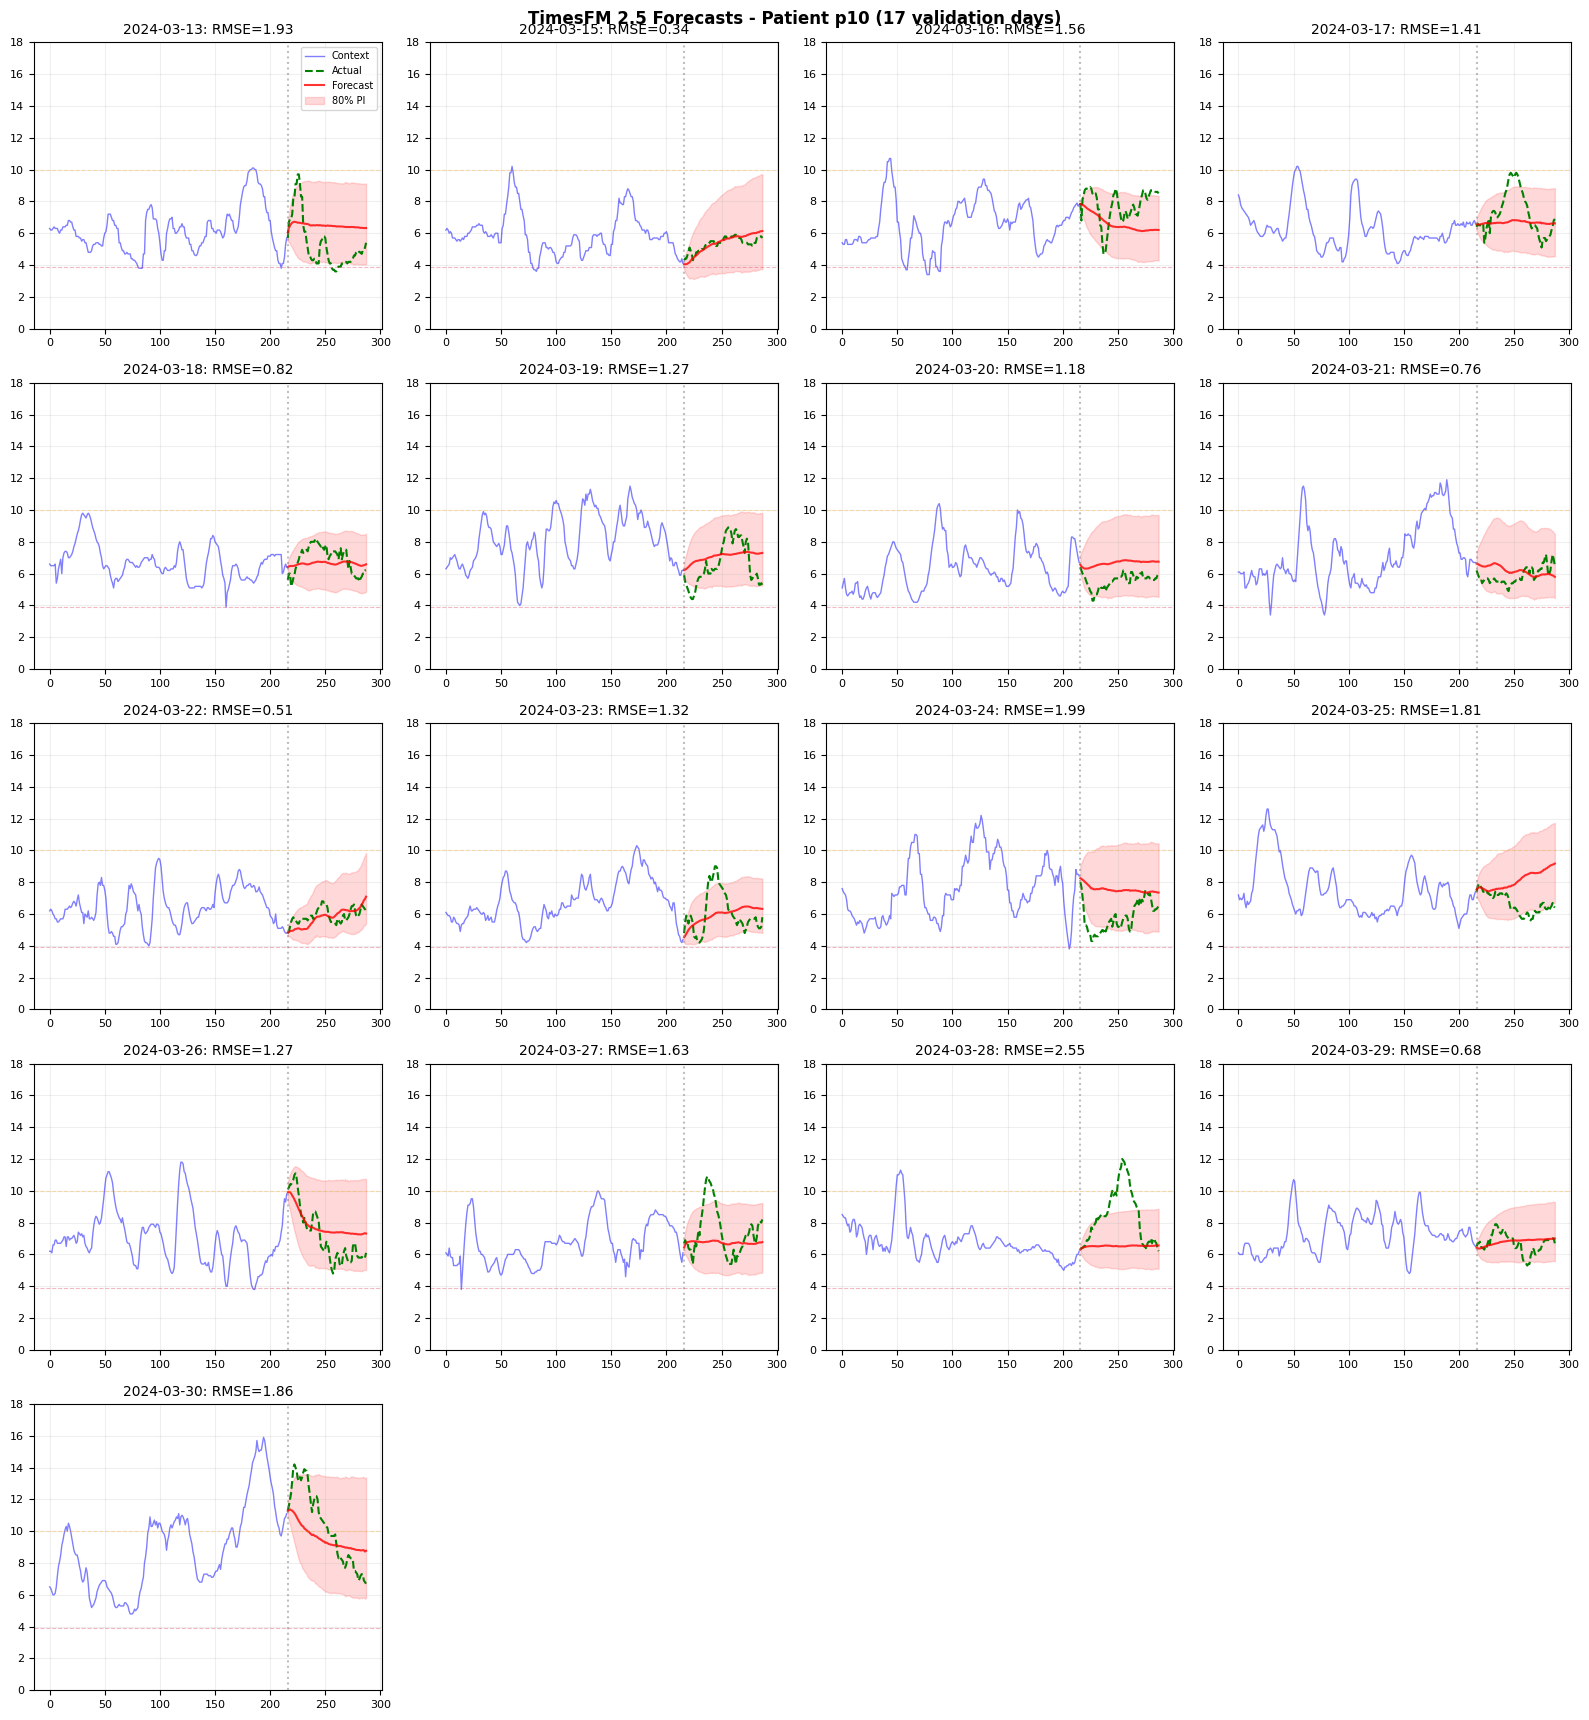

In [8]:
# Plot forecasts for all validation days of patient p10 in a grid
PATIENT = "p10"
patient_df = val_data[PATIENT].sort_index()

# Collect all valid days
p10_forecasts = []
for daytime, nocturnal in iter_daily_context_forecast_splits(patient_df):
    target = nocturnal[TARGET_COL].values[:prediction_length]
    
    if np.isnan(target).any() or len(target) < prediction_length:
        continue
    
    nocturnal_start = nocturnal.index[0]
    available = patient_df.loc[patient_df.index < nocturnal_start, TARGET_COL].dropna()
    
    if len(available) < CONTEXT_LENGTH:
        continue
    
    context = available.iloc[-CONTEXT_LENGTH:].values
    if np.isnan(context).any():
        continue
    
    # Forecast
    pred, quantiles = timesfm_forecast(context, prediction_length)
    pred = pred.flatten()
    q10 = quantiles[:, 1]
    q90 = quantiles[:, 9]
    
    p10_forecasts.append({
        "date": nocturnal_start.date(),
        "context": context,
        "target": target,
        "pred": pred,
        "q10": q10,
        "q90": q90,
        "rmse": compute_metrics(pred, target.flatten())["rmse"]
    })

# Create grid
n_days = len(p10_forecasts)
NCOLS = 4
nrows = int(np.ceil(n_days / NCOLS))

fig, axes = plt.subplots(nrows, NCOLS, figsize=(4 * NCOLS, 3.5 * nrows))
axes = np.array(axes).flatten()

for i, forecast in enumerate(p10_forecasts):
    ax = axes[i]
    
    # Plot (show last 216 steps of context)
    ctx_display = forecast["context"][-216:]
    t_ctx = np.arange(len(ctx_display))
    t_pred = np.arange(len(ctx_display), len(ctx_display) + len(forecast["target"]))
    
    ax.plot(t_ctx, ctx_display, "b-", alpha=0.5, lw=1, label="Context")
    ax.plot(t_pred, forecast["target"], "g--", lw=1.5, label="Actual")
    ax.plot(t_pred, forecast["pred"], "r-", lw=1.5, alpha=0.8, label="Forecast")
    ax.fill_between(t_pred, forecast["q10"], forecast["q90"], alpha=0.15, color="red", label="80% PI")
    
    ax.axvline(len(ctx_display), color="gray", ls=":", alpha=0.5)
    ax.axhline(3.9, color="crimson", ls="--", alpha=0.3, lw=0.8)
    ax.axhline(10.0, color="orange", ls="--", alpha=0.3, lw=0.8)
    
    ax.set_title(f"{forecast['date']}: RMSE={forecast['rmse']:.2f}", fontsize=10)
    ax.set_ylim(0, 18)
    ax.tick_params(labelsize=8)
    ax.grid(alpha=0.2)

# Hide unused subplots
for j in range(n_days, len(axes)):
    axes[j].set_visible(False)

axes[0].legend(fontsize=7, loc="upper right")
fig.suptitle(f"TimesFM 2.5 Forecasts - Patient {PATIENT} ({n_days} validation days)", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

## Summary

### Results
- **Valid patients**: 6 (with 5-minute CGM intervals and sufficient data)
- **Best patient**: p10 (RMSE = 1.46 mmol/L)
- **Worst patient**: p02 (RMSE = 2.99 mmol/L)
- **Overall RMSE**: 2.34 mmol/L

### Key Observations
- TimesFM 2.5 provides reasonable zero-shot forecasts using only historical BG values
- Probabilistic outputs (quantile forecasts) enable uncertainty quantification
- Significant inter-patient variability suggests personalization may help